In [1]:
# Based on notebook from https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [5]:
!python -m pip install torchvision
import torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [11]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [12]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [13]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1*28*28).to(device)
flatten_batch.shape

torch.Size([100, 784])

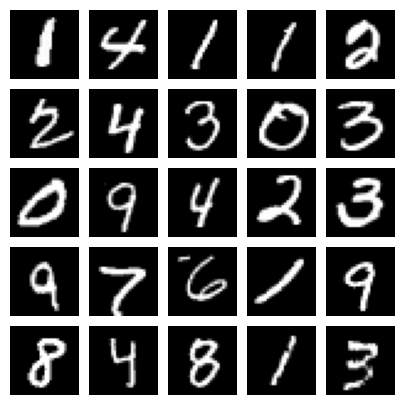

In [14]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [20]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, z_dim=2, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, sdev):
        epsilon = torch.randn_like(sdev).to(device)
        z = mean + sdev*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        sdev = torch.exp(0.5 * logvar) # sdev = sqrt(var)
        z = self.reparameterization(mean, sdev)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [21]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [22]:
torchinfo.summary(model, input_size=(100,784), col_names = ('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                --
├─Sequential: 1-1                        [100, 784]                [100, 200]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─LeakyReLU: 2-2                    [100, 400]                [100, 400]                --
│    └─Linear: 2-3                       [100, 400]                [100, 200]                80,200
│    └─LeakyReLU: 2-4                    [100, 200]                [100, 200]                --
├─Linear: 1-2                            [100, 200]                [100, 2]                  402
├─Linear: 1-3                            [100, 200]                [100, 2]                  402
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-5      

In [23]:
def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

In [24]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [25]:
train(model, optimizer, epochs=10, device=device)

	Epoch 1 	Average Loss:  180.09160529593595
	Epoch 2 	Average Loss:  161.95879289375523
	Epoch 3 	Average Loss:  158.33410653498018
	Epoch 4 	Average Loss:  155.68304542401398
	Epoch 5 	Average Loss:  153.71152258973288
	Epoch 6 	Average Loss:  152.14024994456906
	Epoch 7 	Average Loss:  151.0378159399781
	Epoch 8 	Average Loss:  150.33534122626253
	Epoch 9 	Average Loss:  149.55187234257616
	Epoch 10 	Average Loss:  148.93874709802796


8921430.951171875

In [26]:
def generate_digit(z_dim=2):
    z_sample = torch.randn(size=(1,z_dim)).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{z_sample[0,0]},{z_sample[0,1]}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

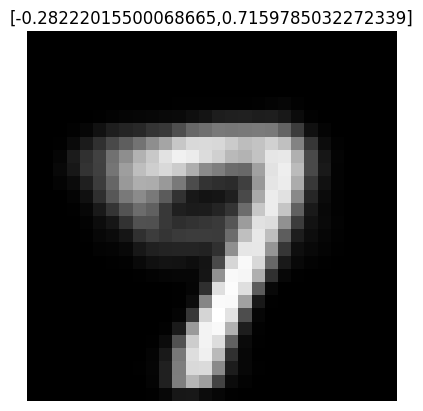

In [27]:
generate_digit()

In [29]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

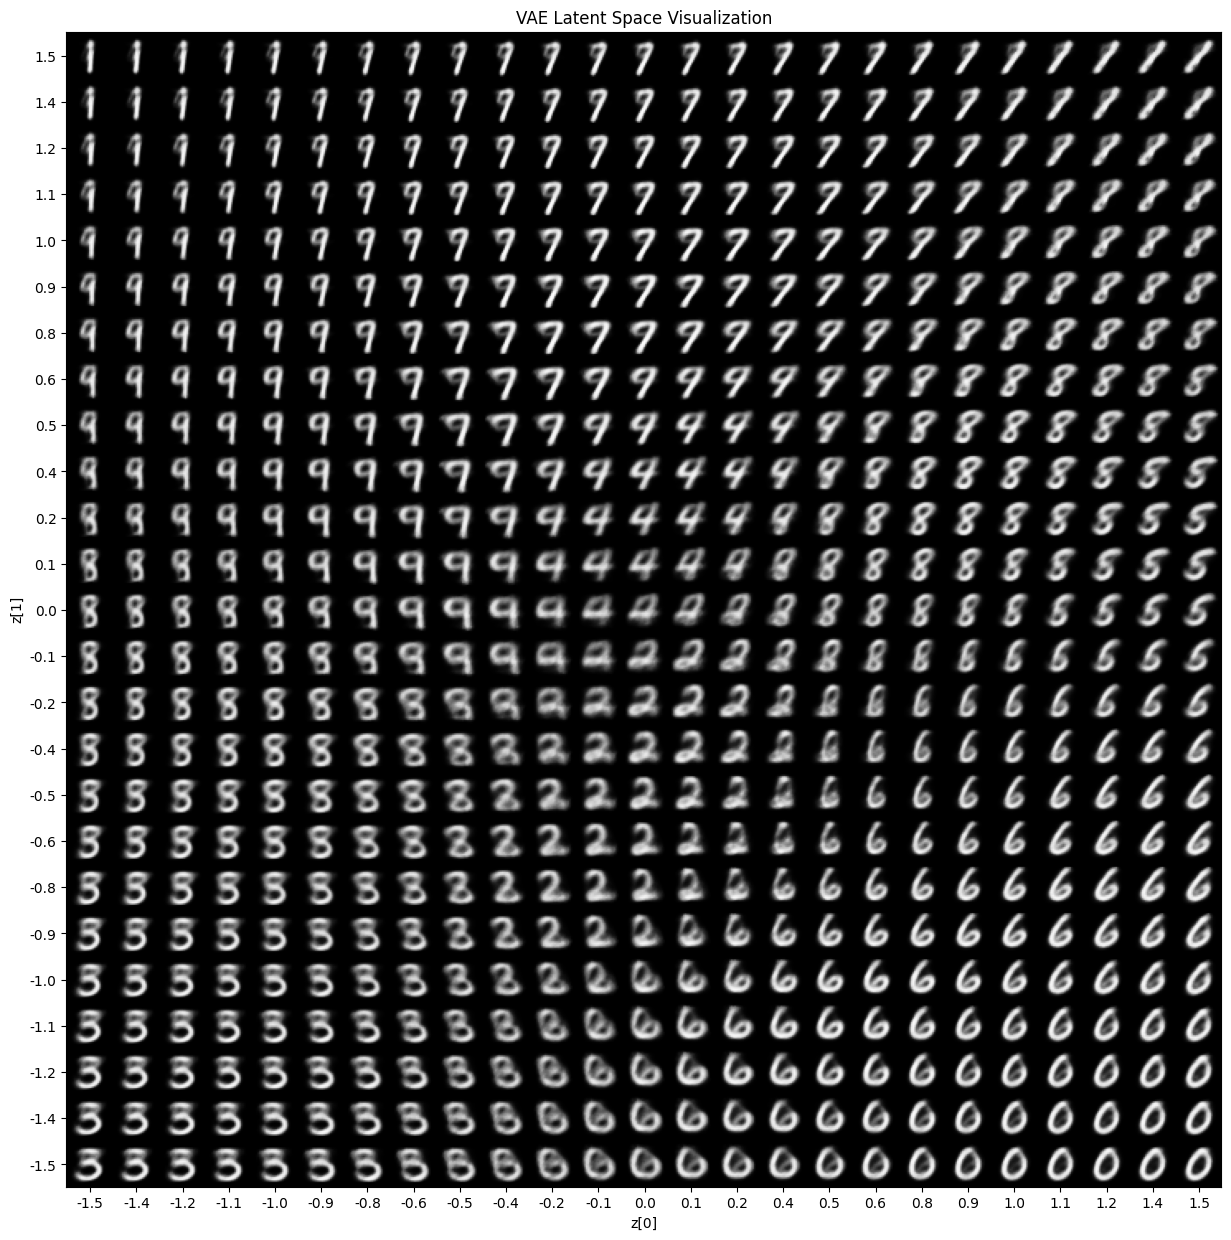

In [35]:
plot_latent_space(model, scale=1.5)

# NADE

In [77]:
class NADE(nn.Module):

    """NADE for binary MNIST"""
    def __init__(self, input_dim, hidden_dim):
        super(NADE, self).__init__()
        self.D = input_dim
        self.N = hidden_dim
        self.params = nn.ParameterDict({
            "V" : nn.Parameter(torch.randn(self.N, self.D)),
            "v" : nn.Parameter(torch.zeros(1, self.N)),
            "A" : nn.Parameter(torch.randn(self.D, self.N)),
            "b" : nn.Parameter(torch.zeros(self.D)),
        })
        nn.init.xavier_normal_(self.params["A"])
        nn.init.xavier_normal_(self.params["V"])

    def forward(self, x):
        # a0: (B, H)
        h = self.params["v"].expand(x.size(0), -1)
        # Compute p(x)
        x_hat = self.get_x_hat(h, x)
        return x_hat
    
    def get_x_hat(self, h, x):
        """
        Parameters:
        B = X
         - h : (X, N)
         - x : (X, D)
         
        Return:
         - x_hat: (X, D), estimated probability dist. of batch data
        """
        x_hat = []  # (X, 1) x D
        for i in range(self.D):
            # h_i: (X, H)
            h_i = torch.sigmoid(h)
            # p_hat: (X, N) x (N, 1) + (X, 1) = (X, 1)
            p_hat = torch.sigmoid(h_i.mm(self.params["A"][i:i+1, :].t() + self.params["b"][i:i+1]))
            x_hat.append(p_hat)

            # a_{d+1}: (B, 1) x (1, H)
            h = x[:, i:i+1].mm(self.params["V"][:, i:i+1].t()) + self.params["v"]
        
        # x_hat: (X, D), estimated probability dist. of batch data
        x_hat = torch.cat(x_hat, 1)
    
        return x_hat
    

In [65]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
model = NADE(input_dim=784, hidden_dim=400).to(device)

In [47]:

loss_function = nn.BCELoss(reduction="sum")
optimizer = Adam(model.parameters(), lr=1e-3)
    

In [75]:
def train(model,optimizer, train_loader, epochs, loss_function, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            
            optimizer.zero_grad()
            x = x.view(batch_size, x_dim)
            x = x.gt(0.).float().to(device)
            x_hat = model(x)
            loss = loss_function(x_hat, x)
            loss.backward()
            optimizer.step()
            
            overall_loss += loss.item()
            
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [79]:
train(model,optimizer, train_loader, 10, loss_function, device, x_dim=784)


KeyboardInterrupt: 